In [79]:

import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
dataset = pd.read_csv('cities_magicbricks_rental_prices.csv')

In [48]:
#rent is  target variable and other variables are assumed as features
threshold = dataset['rent'].median()

In [49]:
#binary classification 
dataset['rent_category'] = (dataset['rent'] > threshold).astype(int) 

In [50]:
features = dataset.drop(columns=['rent', 'rent_category'])  # Replace with feature column names
target = dataset['rent_category']

In [51]:
dataset

,house_type,locality,city,area,beds,bathrooms,balconies,furnishing,area_rate,rent,rent_category
0,"2 BHK Flat for Rent in Oberoi Woods, Goregaon ...",Goregaon East,Mumbai,897.0,2,2,0,Semi-Furnished,134.0,120000.0,1
1,"1 BHK Flat for Rent in Sapphire Lakeside, Powa...",Powai,Mumbai,490.0,1,1,0,Semi-Furnished,82.0,40000.0,1
2,1 BHK House for Rent in Mundhwa Pune,Mundhwa,Pune,550.0,1,1,0,Unfurnished,22.0,12000.0,0
3,"2 BHK Flat for Rent in Hingna, Nagpur",Hingna,Nagpur,1000.0,2,2,0,Unfurnished,8.0,8000.0,0
4,1 BHK Flat for Rent in Unique Star Harsh Vihar...,Mira Road,Mumbai,595.0,1,1,0,Unfurnished,25.0,15000.0,0
...,...,...,...,...,...,...,...,...,...,...,...
7686,"3 BHK Flat for Rent in Saket, New Delhi",Saket,New Delhi,1750.0,3,3,0,Furnished,27.0,47000.0,1
7687,"2 BHK Flat for Rent in Phase 7 JP Nagar, Banga...",Phase 7 JP Nagar,Bangalore,1050.0,2,2,2,Semi-Furnished,27.0,28000.0,0
7688,"2 BHK Flat for Rent in Malpani Vivanta, Balewa...",Balewadi,Pune,734.0,2,2,2,Unfurnished,48.0,35000.0,1
7689,"1 BHK Flat for Rent in Shalimar bagh, New Delhi",Shalimar bagh,New Delhi,400.0,1,1,0,Semi-Furnished,38.0,15000.0,0


In [52]:
numerical_features = features.select_dtypes(include=['int64', 'float64']).columns


In [53]:
categorical_features = features.select_dtypes(include=['object']).columns

In [54]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [55]:
#Random Forests Algorithm

In [56]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [57]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [58]:
roc_auc_values = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []

In [59]:
results = []

In [60]:
def calculate_metrics(tp, tn, fp, fn):
    """Calculates performance metrics."""
    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tss = (tp / (tp + fn)) - (fp / (fp + tn)) if (tp + fn > 0 and fp + tn > 0) else 0
    hss = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) if (tp + fn > 0 and tp + fp > 0) else 0
    return accuracy, precision, recall, fpr, fnr, tss, hss

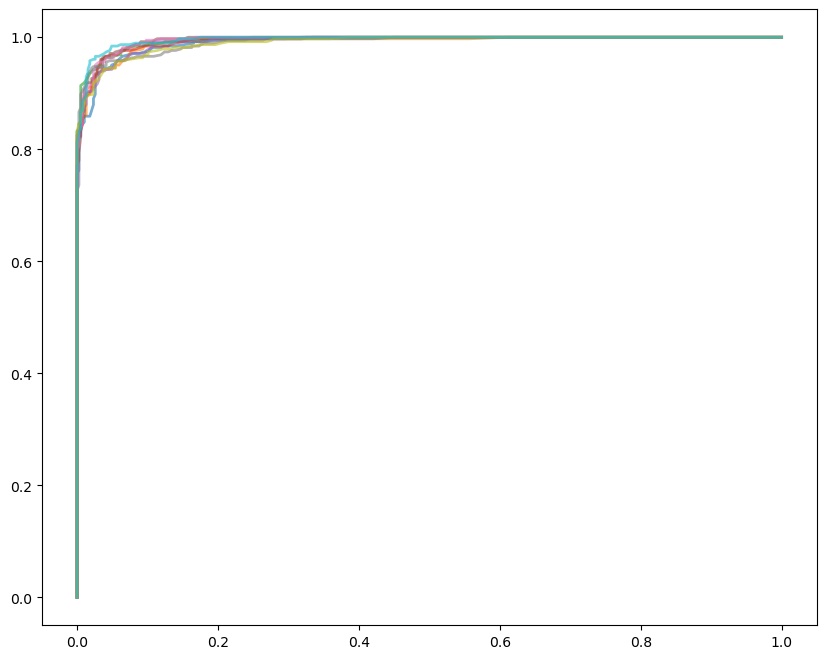

In [61]:
fold = 1
plt.figure(figsize=(10, 8)) 
for train_idx, test_idx in skf.split(features, target):
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Predict
    y_prob = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    accuracy, precision, recall, fpr, fnr, tss, hss = calculate_metrics(tp, tn, fp, fn)
    
    fpr_roc, tpr_roc, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr_roc, tpr_roc)
    roc_auc_values.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr_roc, tpr_roc))
    tprs[-1][0] = 0.0
    
    plt.plot(fpr_roc, tpr_roc, lw=2, alpha=0.6, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

    
    # Append results
    results.append({
        'Fold': fold,
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
        'FPR': fpr, 'FNR': fnr, 'TSS': tss, 'HSS': hss
    })
    fold += 1

In [62]:
# Aggregate results

results_df = pd.DataFrame(results)
overall_metrics = results_df.mean(axis=0).to_dict()
overall_metrics['Fold'] = 'Average'

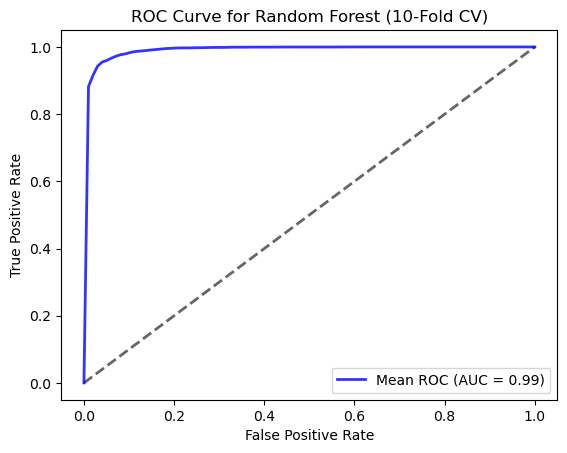

In [63]:
# Final ROC curve
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.6)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8, label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest (10-Fold CV)')
plt.legend(loc='lower right')
plt.show()

In [64]:
results_df = pd.concat([results_df, pd.DataFrame([overall_metrics])], ignore_index=True)

In [65]:
print(results_df)
random_forests_metrics = results_df

       Fold     TP     TN    FP    FN  Accuracy  Precision    Recall  \
0         1  362.0  372.0  15.0  21.0  0.953247   0.960212  0.945170   
1         2  361.0  369.0  17.0  22.0  0.949285   0.955026  0.942559   
2         3  369.0  371.0  15.0  14.0  0.962289   0.960938  0.963446   
3         4  366.0  373.0  13.0  17.0  0.960988   0.965699  0.955614   
4         5  359.0  374.0  12.0  24.0  0.953186   0.967655  0.937337   
5         6  363.0  373.0  14.0  19.0  0.957087   0.962865  0.950262   
6         7  361.0  377.0  10.0  21.0  0.959688   0.973046  0.945026   
7         8  365.0  371.0  16.0  17.0  0.957087   0.958005  0.955497   
8         9  361.0  366.0  21.0  21.0  0.945384   0.945026  0.945026   
9        10  369.0  377.0  10.0  13.0  0.970091   0.973615  0.965969   
10  Average  363.6  372.3  14.3  18.9  0.956833   0.962209  0.950591   

         FPR       FNR       TSS       HSS  
0   0.038760  0.054830  0.906410  0.906483  
1   0.044041  0.057441  0.898517  0.898563  


In [66]:
random_forests_metrics

,Fold,TP,TN,FP,FN,Accuracy,Precision,Recall,FPR,FNR,TSS,HSS
0,1,362.0,372.0,15.0,21.0,0.953247,0.960212,0.945170,0.038760,0.054830,0.906410,0.906483
1,2,361.0,369.0,17.0,22.0,0.949285,0.955026,0.942559,0.044041,0.057441,0.898517,0.898563
2,3,369.0,371.0,15.0,14.0,0.962289,0.960938,0.963446,0.038860,0.036554,0.924586,0.924577
3,4,366.0,373.0,13.0,17.0,0.960988,0.965699,0.955614,0.033679,0.044386,0.921935,0.921972
4,5,359.0,374.0,12.0,24.0,0.953186,0.967655,0.937337,0.031088,0.062663,0.906249,0.906359
5,6,363.0,373.0,14.0,19.0,0.957087,0.962865,0.950262,0.036176,0.049738,0.914086,0.914163
6,7,361.0,377.0,10.0,21.0,0.959688,0.973046,0.945026,0.025840,0.054974,0.919186,0.919357
7,8,365.0,371.0,16.0,17.0,0.957087,0.958005,0.955497,0.041344,0.044503,0.914154,0.914169
8,9,361.0,366.0,21.0,21.0,0.945384,0.945026,0.945026,0.054264,0.054974,0.890763,0.890763
9,10,369.0,377.0,10.0,13.0,0.970091,0.973615,0.965969,0.025840,0.034031,0.940129,0.940176


In [67]:
#KNN Algorithm

In [68]:


# Load dataset (adjust file path and columns as needed)
data = pd.read_csv('cities_magicbricks_rental_prices.csv')

# Preprocessing
# Assuming 'rent' is the target variable. Adjust accordingly.
threshold = data['rent'].median()
data['rent_category'] = (data['rent'] > threshold).astype(int)  # Binary classification

features = data.drop(columns=['rent', 'rent_category'])  # Replace with feature column names
target = data['rent_category']

# Preprocessing pipeline
numerical_features = features.select_dtypes(include=['int64', 'float64']).columns
categorical_features = features.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Model pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))  # Using 5 nearest neighbors
])

# Stratified 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Metrics initialization
results = []


# Cross-validation loop
fold = 1
for train_idx, test_idx in skf.split(features, target):
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    accuracy, precision, recall, fpr, fnr, tss, hss = calculate_metrics(tp, tn, fp, fn)
    
    # Append results
    results.append({
        'Fold': fold,
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
        'FPR': fpr, 'FNR': fnr, 'TSS': tss, 'HSS': hss
    })
    fold += 1
knn_probs = clf.predict_proba(X_test)[:, 1] 
# Aggregate results
results_df = pd.DataFrame(results)
overall_metrics = results_df.mean(axis=0).to_dict()
overall_metrics['Fold'] = 'Average'

# Append overall metrics
results_df = pd.concat([results_df, pd.DataFrame([overall_metrics])], ignore_index=True)

# Display results
print(results_df)


knn_metrics = results_df





       Fold     TP     TN    FP    FN  Accuracy  Precision    Recall  \
0         1  347.0  363.0  24.0  36.0  0.922078   0.935310  0.906005   
1         2  365.0  352.0  34.0  18.0  0.932380   0.914787  0.953003   
2         3  353.0  357.0  29.0  30.0  0.923277   0.924084  0.921671   
3         4  350.0  353.0  33.0  33.0  0.914174   0.913838  0.913838   
4         5  342.0  366.0  20.0  41.0  0.920676   0.944751  0.892950   
5         6  343.0  362.0  25.0  39.0  0.916775   0.932065  0.897906   
6         7  362.0  365.0  22.0  20.0  0.945384   0.942708  0.947644   
7         8  354.0  350.0  37.0  28.0  0.915475   0.905371  0.926702   
8         9  348.0  352.0  35.0  34.0  0.910273   0.908616  0.910995   
9        10  361.0  366.0  21.0  21.0  0.945384   0.945026  0.945026   
10  Average  352.5  358.6  28.0  30.0  0.924588   0.926656  0.921574   

         FPR       FNR       TSS       HSS  
0   0.062016  0.093995  0.843990  0.844126  
1   0.088083  0.046997  0.864920  0.864779  


In [69]:
knn_metrics

,Fold,TP,TN,FP,FN,Accuracy,Precision,Recall,FPR,FNR,TSS,HSS
0,1,347.0,363.0,24.0,36.0,0.922078,0.935310,0.906005,0.062016,0.093995,0.843990,0.844126
1,2,365.0,352.0,34.0,18.0,0.932380,0.914787,0.953003,0.088083,0.046997,0.864920,0.864779
2,3,353.0,357.0,29.0,30.0,0.923277,0.924084,0.921671,0.075130,0.078329,0.846541,0.846550
3,4,350.0,353.0,33.0,33.0,0.914174,0.913838,0.913838,0.085492,0.086162,0.828346,0.828346
4,5,342.0,366.0,20.0,41.0,0.920676,0.944751,0.892950,0.051813,0.107050,0.841137,0.841316
5,6,343.0,362.0,25.0,39.0,0.916775,0.932065,0.897906,0.064599,0.102094,0.833306,0.833504
6,7,362.0,365.0,22.0,20.0,0.945384,0.942708,0.947644,0.056848,0.052356,0.890796,0.890766
7,8,354.0,350.0,37.0,28.0,0.915475,0.905371,0.926702,0.095607,0.073298,0.831094,0.830968
8,9,348.0,352.0,35.0,34.0,0.910273,0.908616,0.910995,0.090439,0.089005,0.820555,0.820542
9,10,361.0,366.0,21.0,21.0,0.945384,0.945026,0.945026,0.054264,0.054974,0.890763,0.890763


In [70]:
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
knn_auc = auc(knn_fpr, knn_tpr)

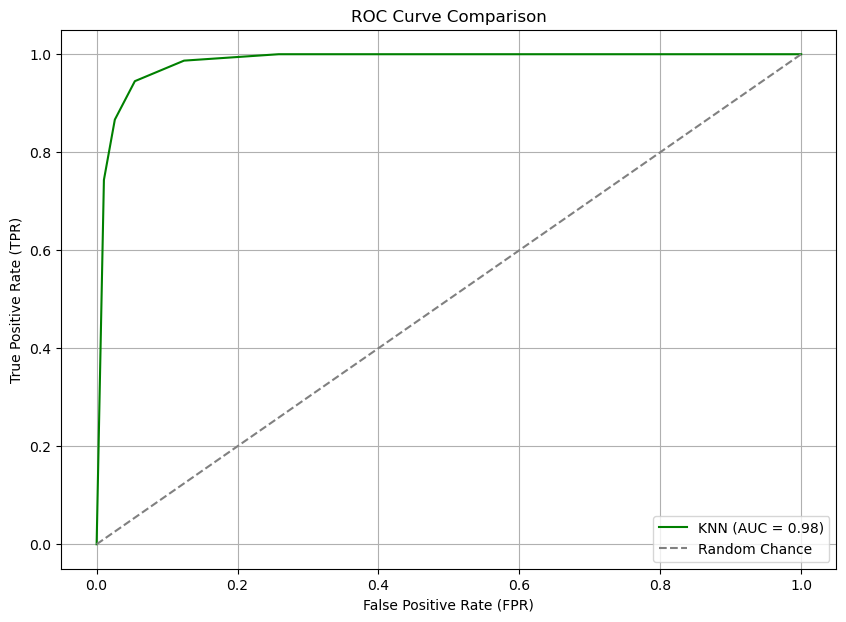

In [71]:

# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(knn_fpr, knn_tpr, label=f"KNN (AUC = {knn_auc:.2f})", color="green")

# Plot the random baseline
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Chance")

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [72]:
#GRU Algorithm

25/25 [==============================] - 0s 853us/step


25/25 [==============================] - 0s 858us/step


25/25 [==============================] - 0s 857us/step


25/25 [==============================] - 0s 829us/step


25/25 [==============================] - 0s 930us/step


25/25 [==============================] - 0s 810us/step


25/25 [==============================] - 0s 843us/step


25/25 [==============================] - 0s 822us/step


25/25 [==============================] - 0s 885us/step


25/25 [==============================] - 0s 821us/step


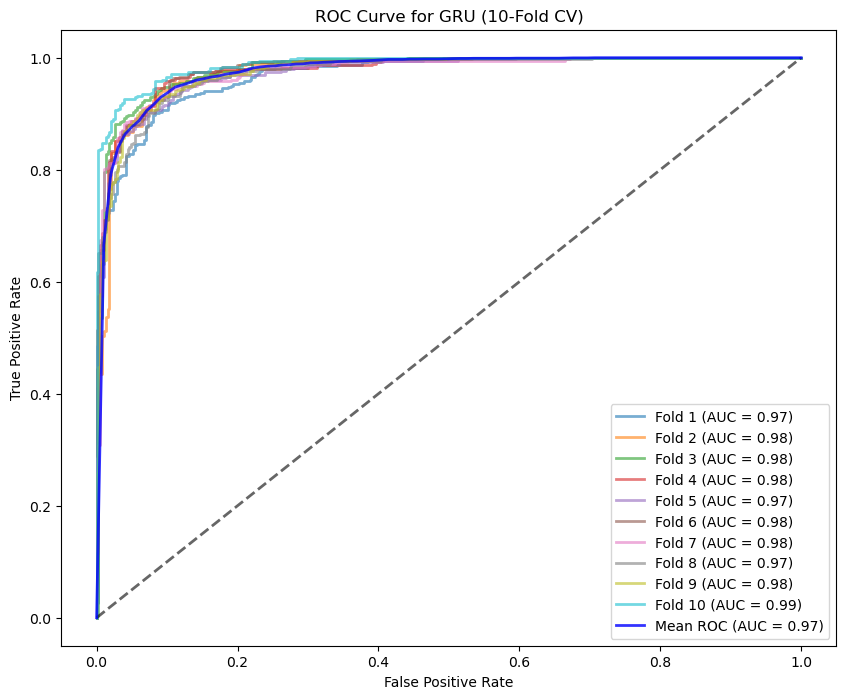

       Fold     TP     TN    FP    FN  Accuracy  Precision    Recall  \
0         1  347.0  349.0  38.0  36.0  0.903896   0.901299  0.906005   
1         2  367.0  341.0  45.0  16.0  0.920676   0.890777  0.958225   
2         3  364.0  345.0  41.0  19.0  0.921977   0.898765  0.950392   
3         4  354.0  354.0  32.0  29.0  0.920676   0.917098  0.924282   
4         5  345.0  358.0  28.0  38.0  0.914174   0.924933  0.900783   
5         6  353.0  351.0  36.0  29.0  0.915475   0.907455  0.924084   
6         7  352.0  354.0  33.0  30.0  0.918075   0.914286  0.921466   
7         8  341.0  359.0  28.0  41.0  0.910273   0.924119  0.892670   
8         9  354.0  351.0  36.0  28.0  0.916775   0.907692  0.926702   
9        10  359.0  356.0  31.0  23.0  0.929779   0.920513  0.939791   
10  Average  353.6  351.8  34.8  28.9  0.917178   0.910694  0.924440   

         FPR       FNR       TSS       HSS  
0   0.098191  0.093995  0.807814  0.807792  
1   0.116580  0.041775  0.841644  0.841397  


In [73]:

# Load dataset (adjust file path and columns as needed)
data = pd.read_csv('cities_magicbricks_rental_prices.csv')

# Preprocessing
threshold = data['rent'].median()
data['rent_category'] = (data['rent'] > threshold).astype(int)  # Binary classification

features = data.drop(columns=['rent', 'rent_category'])  # Replace with feature column names
target = data['rent_category']

# Preprocessing pipeline
numerical_features = features.select_dtypes(include=['int64', 'float64']).columns
categorical_features = features.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X = preprocessor.fit_transform(features)
y = target.values

# Reshape input for GRU (required to have 3 dimensions: samples, timesteps, features)
X = X.toarray() if hasattr(X, "toarray") else X  # Convert sparse matrix to dense if needed
X = X.reshape((X.shape[0], 1, X.shape[1]))  # Treat each sample as a "sequence" of 1 timestep

# Stratified 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Metrics initialization
results = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []
roc_auc_values = []


# Cross-validation loop
fold = 1
plt.figure(figsize=(10, 8))  # Initialize the plot for the ROC curve
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Convert target to categorical for GRU
    y_train_cat = to_categorical(y_train, num_classes=2)
    y_test_cat = to_categorical(y_test, num_classes=2)
    
    # Build GRU model
    model = Sequential([
        GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train model
    model.fit(X_train, y_train_cat, epochs=50, batch_size=32, validation_data=(X_test, y_test_cat), callbacks=[early_stopping], verbose=0)
   
    # Predict probabilities for ROC curve
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    accuracy, precision, recall, fpr, fnr, tss, hss = calculate_metrics(tp, tn, fp, fn)
    
    # Append results
    results.append({
        'Fold': fold,
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
        'FPR': fpr, 'FNR': fnr, 'TSS': tss, 'HSS': hss
    })
    
    # Calculate ROC AUC
    fpr_roc, tpr_roc, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr_roc, tpr_roc)
    roc_auc_values.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr_roc, tpr_roc))
    tprs[-1][0] = 0.0
    
    plt.plot(fpr_roc, tpr_roc, lw=2, alpha=0.6, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
    fold += 1

# Final ROC curve
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.6)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8, label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GRU (10-Fold CV)')
plt.legend(loc='lower right')

plt.show()

# Aggregate results
results_df = pd.DataFrame(results)
overall_metrics = results_df.mean(axis=0).to_dict()
overall_metrics['Fold'] = 'Average'

# Append overall metrics
results_df = pd.concat([results_df, pd.DataFrame([overall_metrics])], ignore_index=True)

# Save results

# Display results
print(results_df)


In [74]:
Gru_metrics = results_df

In [75]:
Gru_metrics

,Fold,TP,TN,FP,FN,Accuracy,Precision,Recall,FPR,FNR,TSS,HSS
0,1,347.0,349.0,38.0,36.0,0.903896,0.901299,0.906005,0.098191,0.093995,0.807814,0.807792
1,2,367.0,341.0,45.0,16.0,0.920676,0.890777,0.958225,0.116580,0.041775,0.841644,0.841397
2,3,364.0,345.0,41.0,19.0,0.921977,0.898765,0.950392,0.106218,0.049608,0.844174,0.843986
3,4,354.0,354.0,32.0,29.0,0.920676,0.917098,0.924282,0.082902,0.075718,0.841380,0.841355
4,5,345.0,358.0,28.0,38.0,0.914174,0.924933,0.900783,0.072539,0.099217,0.828244,0.828328
5,6,353.0,351.0,36.0,29.0,0.915475,0.907455,0.924084,0.093023,0.075916,0.831061,0.830962
6,7,352.0,354.0,33.0,30.0,0.918075,0.914286,0.921466,0.085271,0.078534,0.836195,0.836152
7,8,341.0,359.0,28.0,41.0,0.910273,0.924119,0.892670,0.072351,0.107330,0.820319,0.820499
8,9,354.0,351.0,36.0,28.0,0.916775,0.907692,0.926702,0.093023,0.073298,0.833678,0.833566
9,10,359.0,356.0,31.0,23.0,0.929779,0.920513,0.939791,0.080103,0.060209,0.859687,0.859571


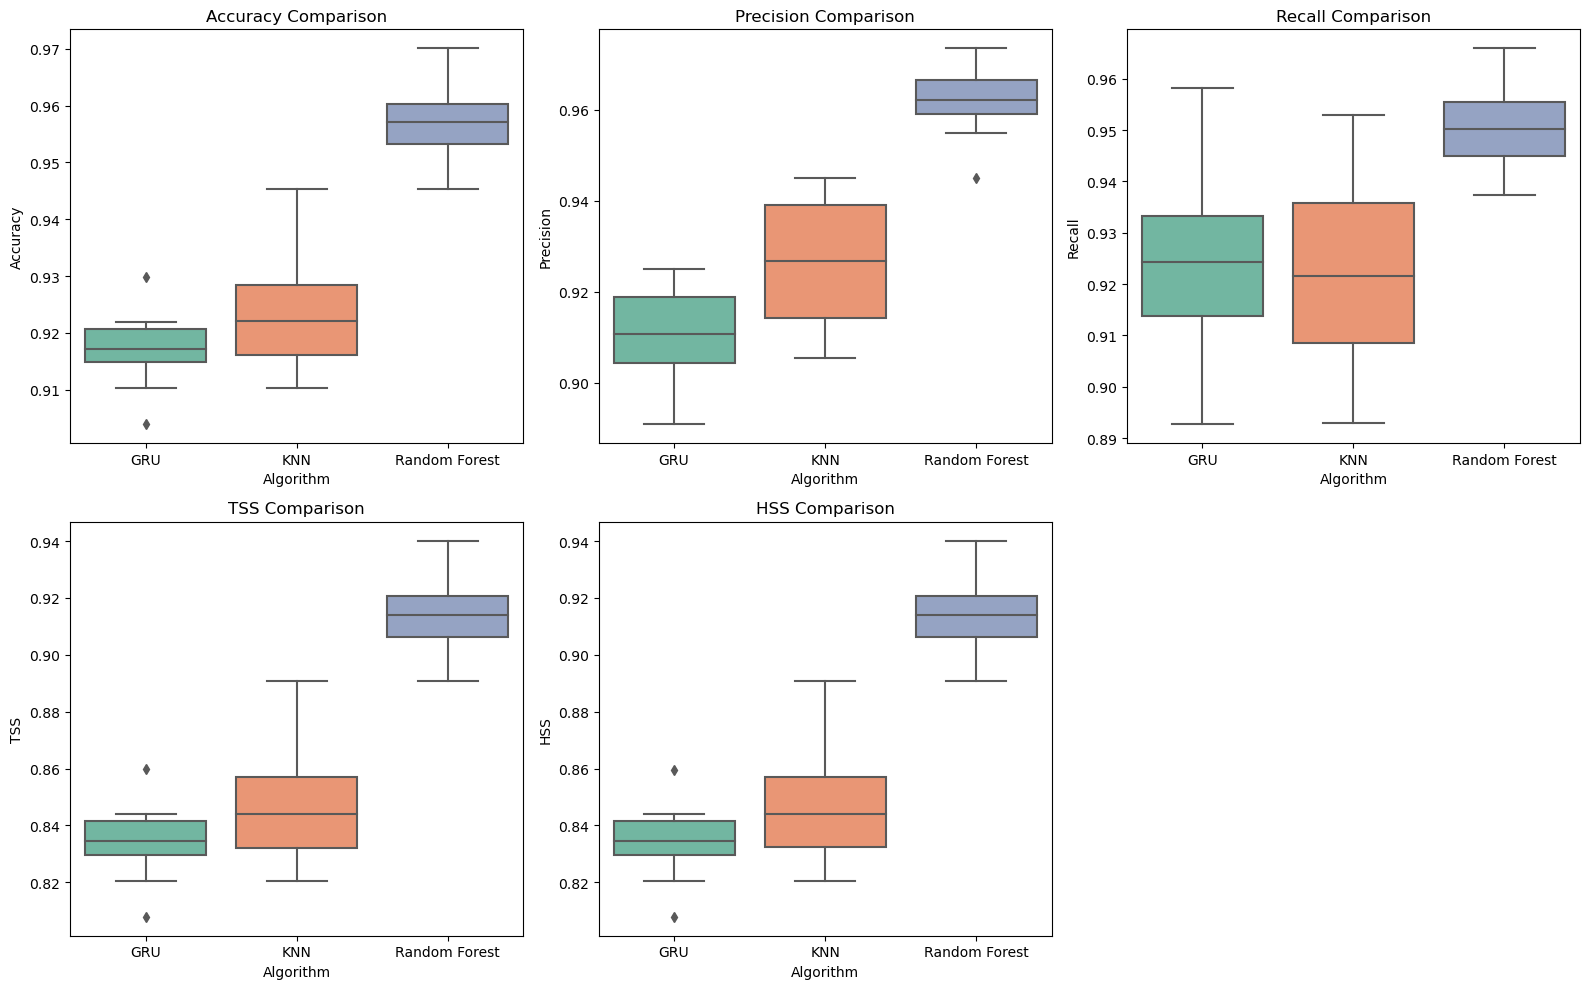

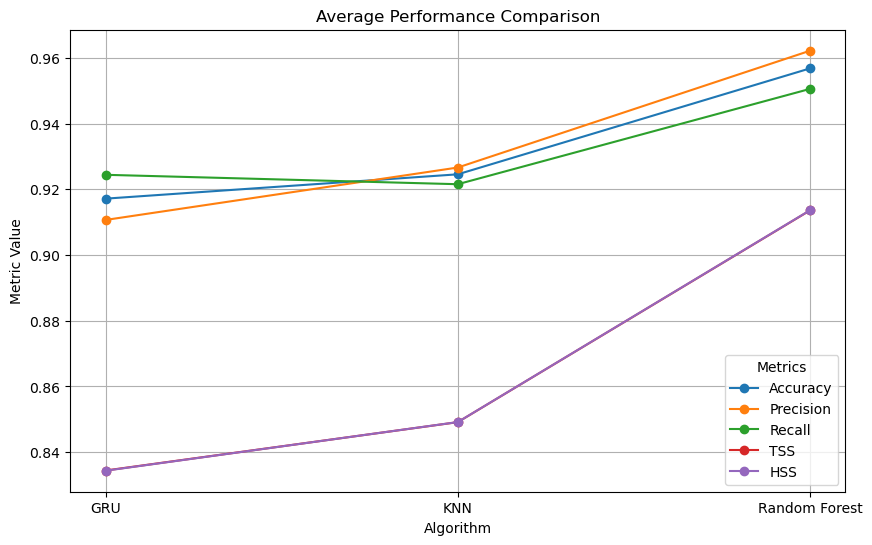

In [82]:
# Adding an algorithm identifier for each data frame
Gru_metrics['Algorithm'] = 'GRU'
knn_metrics['Algorithm'] = 'KNN'
random_forests_metrics['Algorithm'] = 'Random Forest'

# Combine all metrics for comparison
all_metrics = pd.concat([Gru_metrics, knn_metrics, random_forests_metrics], ignore_index=True)

# Select metrics for visualization
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'TSS', 'HSS']

# Visualization
plt.figure(figsize=(16, 10))
for i, metric in enumerate(metrics_to_plot, start=1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=all_metrics, x='Algorithm', y=metric, palette='Set2')
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Algorithm')

plt.tight_layout()
 
plt.show()

# Line plot for average performance per algorithm
average_metrics = all_metrics.groupby('Algorithm')[metrics_to_plot].mean().reset_index()

plt.figure(figsize=(10, 6))
for metric in metrics_to_plot:
    plt.plot(average_metrics['Algorithm'], average_metrics[metric], marker='o', label=metric)

plt.title('Average Performance Comparison')
plt.ylabel('Metric Value')
plt.xlabel('Algorithm')
plt.legend(title='Metrics', loc='lower right')
plt.grid()
plt.show()